In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [2]:
df = pd.read_csv('data/stats.csv')
df.describe()

,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,59.597500,146.863500,28.324500,12.85130,12.838400,12.752800,12.752900,12.41650,12.870100
std,13.283107,68.304729,2.360245,2.96494,2.945531,2.924953,2.947119,2.89283,2.974746
min,33.000000,39.000000,25.000000,3.00000,3.000000,3.000000,3.000000,3.00000,3.000000
25%,52.000000,120.000000,25.000000,11.00000,11.000000,11.000000,11.000000,10.00000,11.000000
50%,64.000000,154.000000,30.000000,13.00000,13.000000,13.000000,13.000000,13.00000,13.000000
75%,69.000000,188.000000,30.000000,15.00000,15.000000,15.000000,15.000000,15.00000,15.000000
max,82.000000,367.000000,30.000000,20.00000,20.000000,20.000000,20.000000,19.00000,20.000000


# EDA

In [3]:
df.race.value_counts(normalize=True)

dragonborn    0.1144
halfling      0.1135
gnome         0.1121
human         0.1120
tiefling      0.1120
elf           0.1112
dwarf         0.1095
half.elf      0.1086
half.orc      0.1067
Name: race, dtype: float64

The target distribution is pretty balanced. The baseline model that simply predicts the most common class would achieve an accuracy of 11.44%. 

In [4]:
def grouped_boxplot(x, group, data):
    sorted_index = df.groupby(group)[x].median().sort_values(ascending=False).index
    return sns.boxplot(y=group, x=x, data=data, order=sorted_index)

In [5]:
y = df.race
X = df.drop(columns='race')

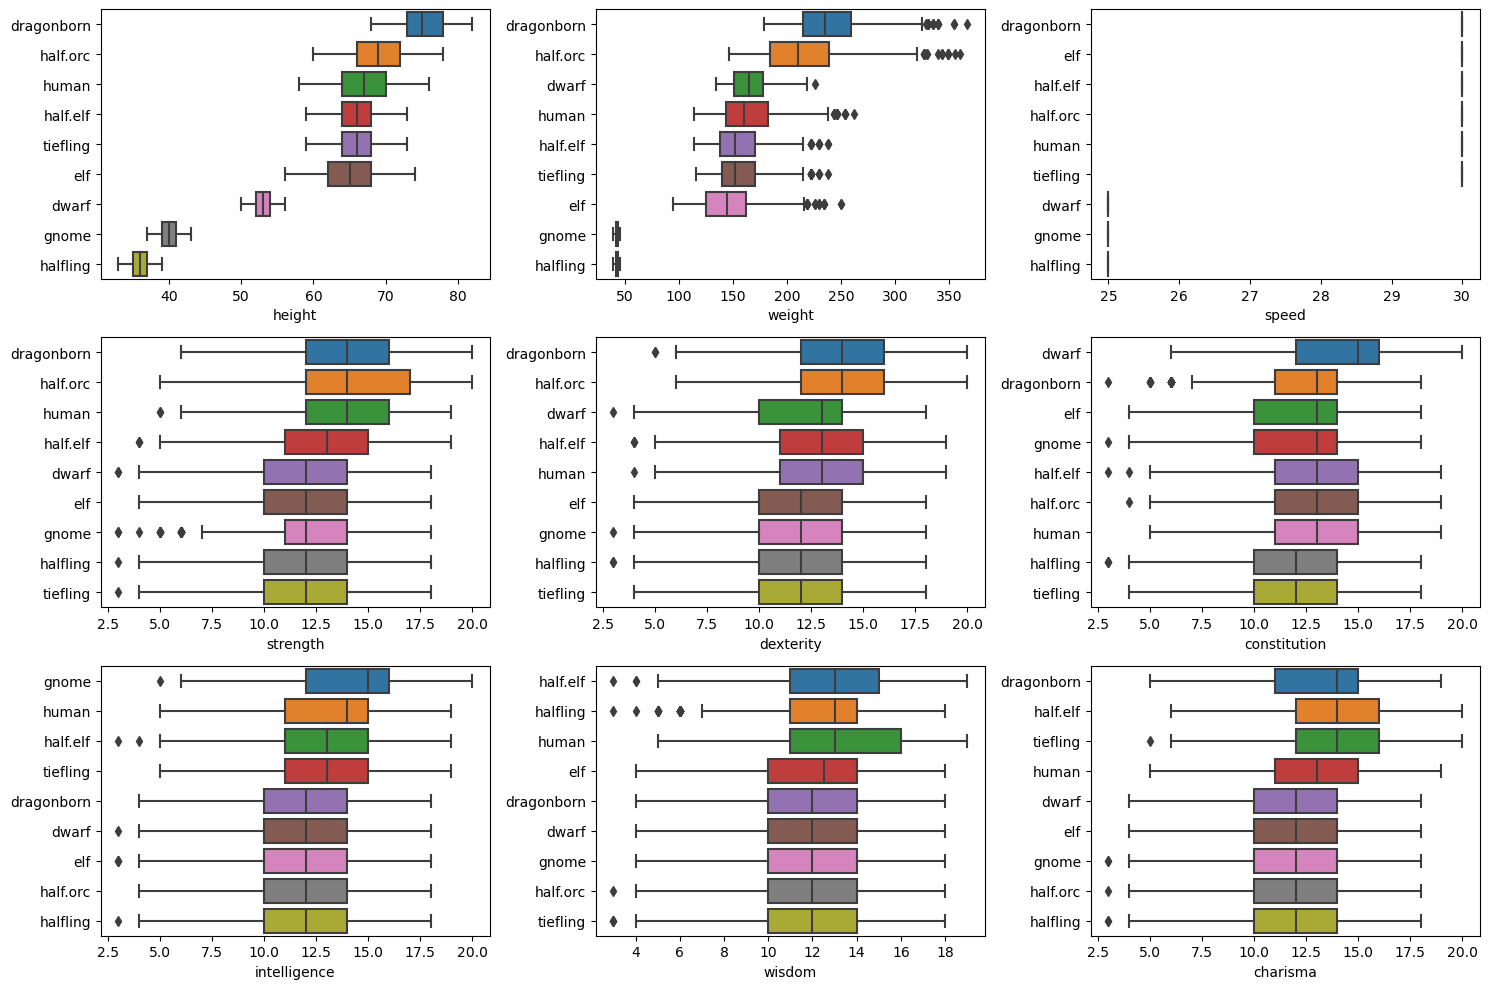

In [6]:
nsubplots = X.shape[1] # one subplot for each predictor
ncols = round(nsubplots**0.5)
nrows = (nsubplots // ncols) + (nsubplots % ncols)
position = range(1, nsubplots + 1)

fig = plt.figure(figsize=(15, 10))
for i in range(nsubplots):
    ax = fig.add_subplot(nrows, ncols, position[i])
    ax = grouped_boxplot(X.columns[i], 'race', df)
    ax.set(ylabel=None)
fig.tight_layout()
plt.show()

Height, weight, and speed appear to be the most informative predictors.

Let's check for pairwise correlations among the predictors. 

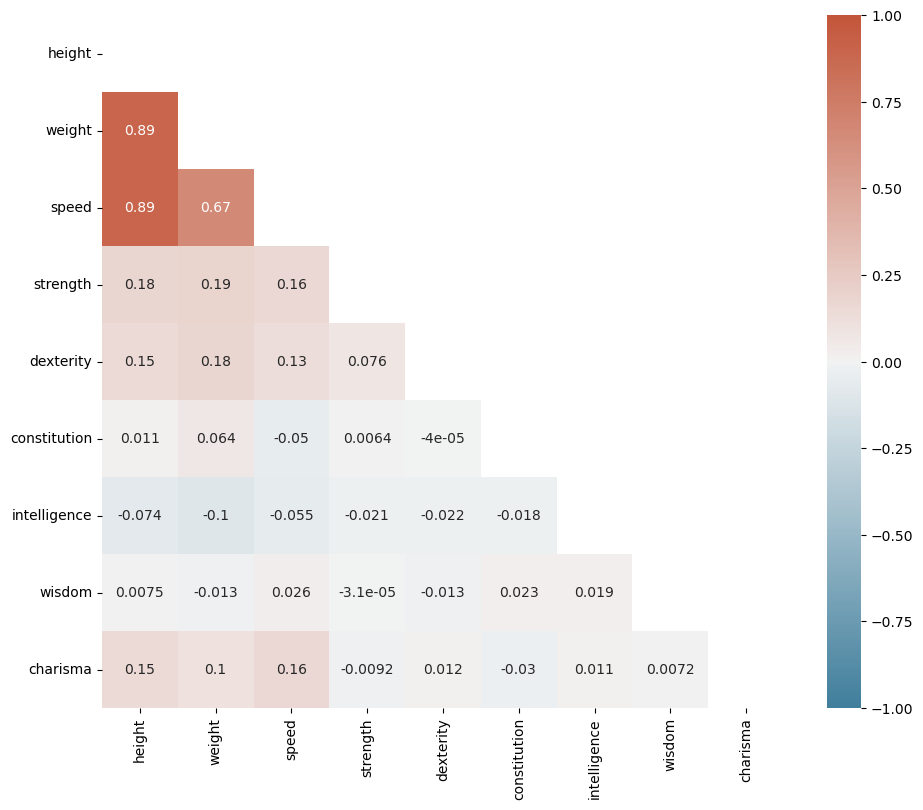

In [7]:
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, center=0, vmin=-1, vmax=1)
plt.show()

Heigh, weight, and speed are strongly positively correlated with each other.

# Principal Component Analysis

In [8]:
scaler = StandardScaler()
pca = PCA()

In [9]:
X_scaled = scaler.fit_transform(X)
pca.fit(X_scaled)
loadings = pd.DataFrame(pca.components_, columns=X.columns)
loadings['explained_var'] = pca.explained_variance_ratio_
loadings['explained_var_cumsum'] = loadings['explained_var'].cumsum()
loadings

,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma,explained_var,explained_var_cumsum
0,-0.585519,-0.541646,-0.537353,-0.172207,-0.151413,-0.007221,0.075824,-0.005088,-0.128961,0.309335,0.309335
1,-0.044534,0.069725,-0.126655,0.335846,0.272919,0.506953,-0.405593,-0.125840,-0.593711,0.118774,0.428109
2,-0.036694,-0.030802,-0.020967,0.076955,0.226286,-0.554035,-0.184422,-0.773400,-0.032003,0.113938,0.542046
3,0.045386,0.049613,0.024535,-0.480906,-0.422670,0.259103,-0.643119,-0.218406,0.237737,0.110581,0.652627
4,-0.028740,-0.051763,0.021408,0.128041,-0.042573,-0.572187,-0.558123,0.553568,-0.180255,0.106411,0.759038
5,0.086219,0.056167,0.092448,0.327585,-0.811541,-0.096992,0.181930,-0.171943,-0.377999,0.103777,0.862815
6,0.132756,0.110519,0.121112,-0.704083,0.097568,-0.138564,0.188291,0.024875,-0.628465,0.099615,0.962430
7,0.008029,0.700827,-0.696986,-0.028636,-0.052152,-0.113323,0.044350,0.040844,0.054499,0.034651,0.997081
8,-0.791094,0.434904,0.429774,-0.010003,-0.009099,0.003183,0.010523,-0.000069,0.004435,0.002919,1.000000


The first principal component accounts for 31% of the variance in the feature space. The features that contribute most to it are height, weight, and speed, which we saw above are all strongly correlated. So the first component can be thought of as a representation of the character's size.

In [10]:
X_pca = pca.transform(X_scaled)
df_pca = pd.DataFrame(X_pca[:,:2], columns=['PCA1', 'PCA2'])
df_pca['race'] = df.race

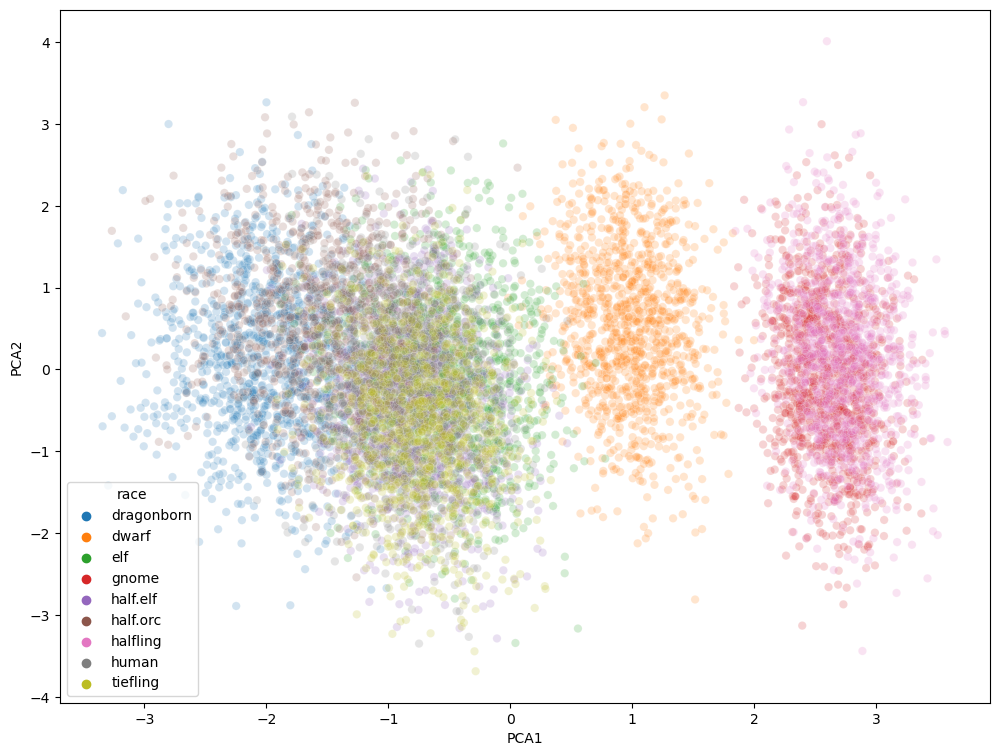

In [11]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='race', alpha=0.2)
plt.show()

The races cluster pretty well along the first principal component (size), but not very well along the second component (ability scores). This corroborates what we saw in the boxplots above. 

# Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train Classifier

Perform pre-processing (scaling and PCA) in a pipeline to avoid any leakage from the validation or test sets. 

In [13]:
pipe = make_pipeline(
    StandardScaler(),
    PCA(),
    KNeighborsClassifier()
)

In [14]:
param_grid = dict(
    kneighborsclassifier__weights=['uniform', 'distance'],
    kneighborsclassifier__n_neighbors=np.arange(1, 51)
)

In [15]:
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [16]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [17]:
cv_results = pd.DataFrame({
    'CV mean accuracy': grid_search.cv_results_['mean_test_score'],
    'weights': [params['kneighborsclassifier__weights'] for params in grid_search.cv_results_['params']],
    'n neighbors': [params['kneighborsclassifier__n_neighbors'] for params in grid_search.cv_results_['params']]
})

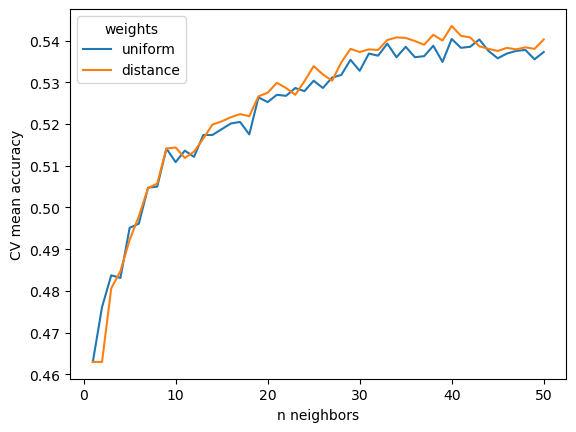

In [18]:
sns.lineplot(data=cv_results, x='n neighbors', y='CV mean accuracy', hue='weights')
plt.show()

In [19]:
'The model that yielded the highest mean cross-validated accuracy of {0} used {1} neighbors and {2} weighting'.format(
    grid_search.best_score_, 
    grid_search.best_params_['kneighborsclassifier__n_neighbors'], 
    grid_search.best_params_['kneighborsclassifier__weights']
)

'The model that yielded the highest mean cross-validated accuracy of 0.5435 used 40 neighbors and distance weighting'

In [20]:
clf = grid_search.best_estimator_ 

# Test Classifier

In [21]:
y_pred = clf.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  dragonborn       0.62      0.73      0.67       210
       dwarf       1.00      1.00      1.00       217
         elf       0.35      0.43      0.39       212
       gnome       0.69      0.65      0.67       241
    half.elf       0.26      0.24      0.25       216
    half.orc       0.39      0.28      0.33       203
    halfling       0.67      0.71      0.69       241
       human       0.31      0.23      0.27       239
    tiefling       0.30      0.38      0.34       221

    accuracy                           0.52      2000
   macro avg       0.51      0.52      0.51      2000
weighted avg       0.51      0.52      0.51      2000



The tuned model achieved 51.8% accuracy on the test set. This is a substantial improvement over the baseline model that simply always predicts the most common class. 

The model perfectly predicted dwarves. This is unsurprising given that dwarves formed their own cluster in the first two principal components. The model performed fairly well on gnomes and halflings. It was able to perfectly distinguish them from any of the other races, but struggled to distinguish them from one another (see below confusion matrix). This aligns with the plot of the first two principal components, which showed gnomes and halflings forming their own cluster. The model also performed moderately well on dragonborn, most often confusing them for half-orcs, the second largest race. The model struggled the most with the remaining races: elves, half-elves, half-orcs, humans, and tieflings. This is unsurprising given their large overlap in the first principal components.  

In [23]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=clf.classes_,
    columns=clf.classes_
)

,dragonborn,dwarf,elf,gnome,half.elf,half.orc,halfling,human,tiefling
dragonborn,154,0,3,0,5,35,0,4,9
dwarf,0,217,0,0,0,0,0,0,0
elf,4,0,91,0,32,7,0,29,49
gnome,0,0,0,156,0,0,85,0,0
half.elf,1,0,44,0,51,11,0,37,72
half.orc,70,0,23,0,15,57,0,23,15
halfling,0,0,0,70,0,0,171,0,0
human,15,0,51,0,41,28,0,55,49
tiefling,6,0,45,0,49,9,0,28,84
